In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import firedrake
import icepack, icepack.models, icepack.plot
from icepack.constants import ice_density as ρ_I, water_density as ρ_W

In [2]:
Lx, Ly = 50e3, 12e3
nx, ny = 48, 32
mesh2d = firedrake.RectangleMesh(nx, ny, Lx, Ly)
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)

In [3]:
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='DG', vdegree=0)
V = firedrake.VectorFunctionSpace(mesh, dim=2, family='CG', degree=2, vfamily='GL', vdegree=5)

In [4]:
from icepack.constants import (ice_density as ρ_I, water_density as ρ_W,
                               gravity as g)

x, y, ζ = firedrake.SpatialCoordinate(mesh)

In [5]:
b_in, b_out = 200, -400
b = firedrake.interpolate(b_in - (b_in - b_out) * x / Lx, Q)

s_in, s_out = 850, 50
s0 = firedrake.interpolate(s_in - (s_in - s_out) * x / Lx, Q)

h0 = firedrake.interpolate(s0 - b, Q)

In [6]:
h_in = s_in - b_in
δs_δx = (s_out - s_in) / Lx
τ_D = -ρ_I * g * h_in * δs_δx

In [7]:
u_in, u_out = 0.0, 2400
velocity_x = u_in + (u_out - u_in) * (x/Lx)**2
u0 = firedrake.interpolate(firedrake.as_vector((velocity_x, 0)), V)

In [8]:
temp = 255.0
A = firedrake.Constant(icepack.rate_factor(temp))

In [9]:
from icepack.constants import weertman_sliding_law as m
C = firedrake.interpolate((0.95 - 0.40 * firedrake.sin(10*firedrake.pi*x/Lx)) * τ_D / 20.0**(1/m),Q)

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I

In [10]:
beta = firedrake.interpolate(C,Q)

In [11]:
import icepack.models.hybrid
def friction(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    s = kwargs['surface']
    C = kwargs['friction']
    
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.hybrid.bed_friction(
        velocity=u, 
        friction=C * ϕ
    )

In [12]:
model = icepack.models.HybridModel(friction=friction)
opts = {'dirichlet_ids': [1], 'side_wall_ids': [3, 4]}
solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C
)

In [13]:
age_model = icepack.models.AgeTransport()
age_solver = icepack.solvers.AgeSolver(age_model)

In [14]:
import tqdm
import os
num_years = 10000
timesteps_per_year = .2

δt = 1.0 / timesteps_per_year
num_timesteps = int(num_years * timesteps_per_year)

a = firedrake.interpolate(firedrake.Constant(1.0), Q)
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)
s = icepack.compute_surface(thickness=h, bed=b)

if not os.path.exists('degree-5.h5'):
    for step in tqdm.trange(num_timesteps):
        h = solver.prognostic_solve(
            δt,
            thickness=h,
            velocity=u,
            accumulation=a,
            thickness_inflow=h0
        )
        s = icepack.compute_surface(thickness=h, bed=b)
    
        u = solver.diagnostic_solve(
            velocity=u,
            thickness=h,
            surface=s,
            fluidity=A,
            friction=C
        )
    
    with firedrake.DumbCheckpoint(
        'degree-5', mode=firedrake.FILE_CREATE
    ) as checkpoint:
        checkpoint.store(h, name='thickness')
        checkpoint.store(s, name='surface')
        checkpoint.store(u, name='velocity')

else:    
    with firedrake.DumbCheckpoint(
        'degree-5', mode=firedrake.FILE_READ
    ) as checkpoint:
        checkpoint.load(h, name='thickness')
        checkpoint.load(s, name='surface')
        checkpoint.load(u, name='velocity')

In [23]:
Q3D = firedrake.FunctionSpace(mesh, family='CG', degree=2, vfamily='GL', vdegree=1+V.ufl_element().degree()[1])
w=firedrake.interpolate(icepack.utilities.vertical_velocity(u,h),Q3D)

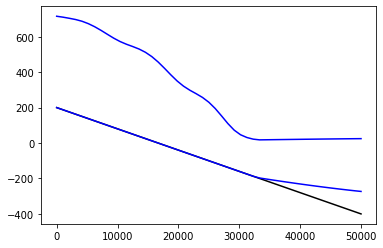

In [24]:
import numpy as np
xs = np.array([(Lx * k / nx, 0, .5) for k in range(nx + 1)])
ss = np.array(s.at(xs, tolerance=1e-10))
hs = np.array(h.at(xs, tolerance=1e-10))
bs = np.array(b.at(xs, tolerance=1e-10))

fig, axes = plt.subplots()
axes.plot(xs[:, 0], bs, color='black')
axes.plot(xs[:, 0], ss - hs, color='blue')
axes.plot(xs[:, 0], ss, color='blue')
plt.show(fig)

In [25]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

nz=20

xz = np.array([(Lx * k / nx, 0, i)  for k in range(nx + 1) for i in np.arange(0.0,1.0,1.0/nz)])
wM= np.array(w.at(xz, tolerance=1e-10))
wM=np.reshape(wM,(49,nz));
xz=np.reshape(xz,(49,nz,3));
hz=np.reshape(np.repeat(hs,nz),(49,nz));
hz=np.multiply(xz[:,:,2],hz);



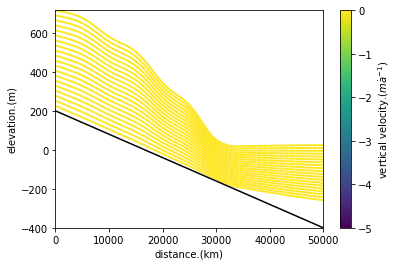

In [26]:
fig, axs = plt.subplots()
for i in range(0,nz):
    points = np.array([np.squeeze(xz[:,i,0]),np.squeeze(ss-hz[:,i])]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    norm = plt.Normalize(-5, 0)
    lc = LineCollection(segments, cmap='viridis', norm=norm)
    # Set the values used for colormapping
    lc.set_array(np.squeeze(wM[:,nz-1-i]))
    lc.set_linewidth(2)
    line = axs.add_collection(lc)
axs.set_xlim(xz.min(), xz.max())
axs.set_ylim(bs.min(), ss.max())
axs.plot(xs[:, 0], bs, color='black')
fig.colorbar(line, ax=axs,label=r'vertical velocity.$(m\dota^{-1})$')
axs.set_ylabel('elevation.(m)')
axs.set_xlabel('distance.(km)')
plt.show()